=== Bayesian Linear Regression Demo ===

1. Posterior Evolution with Data


C:\Users\Petrb\AppData\Local\Temp\ipykernel_95628\2100269242.py:368: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


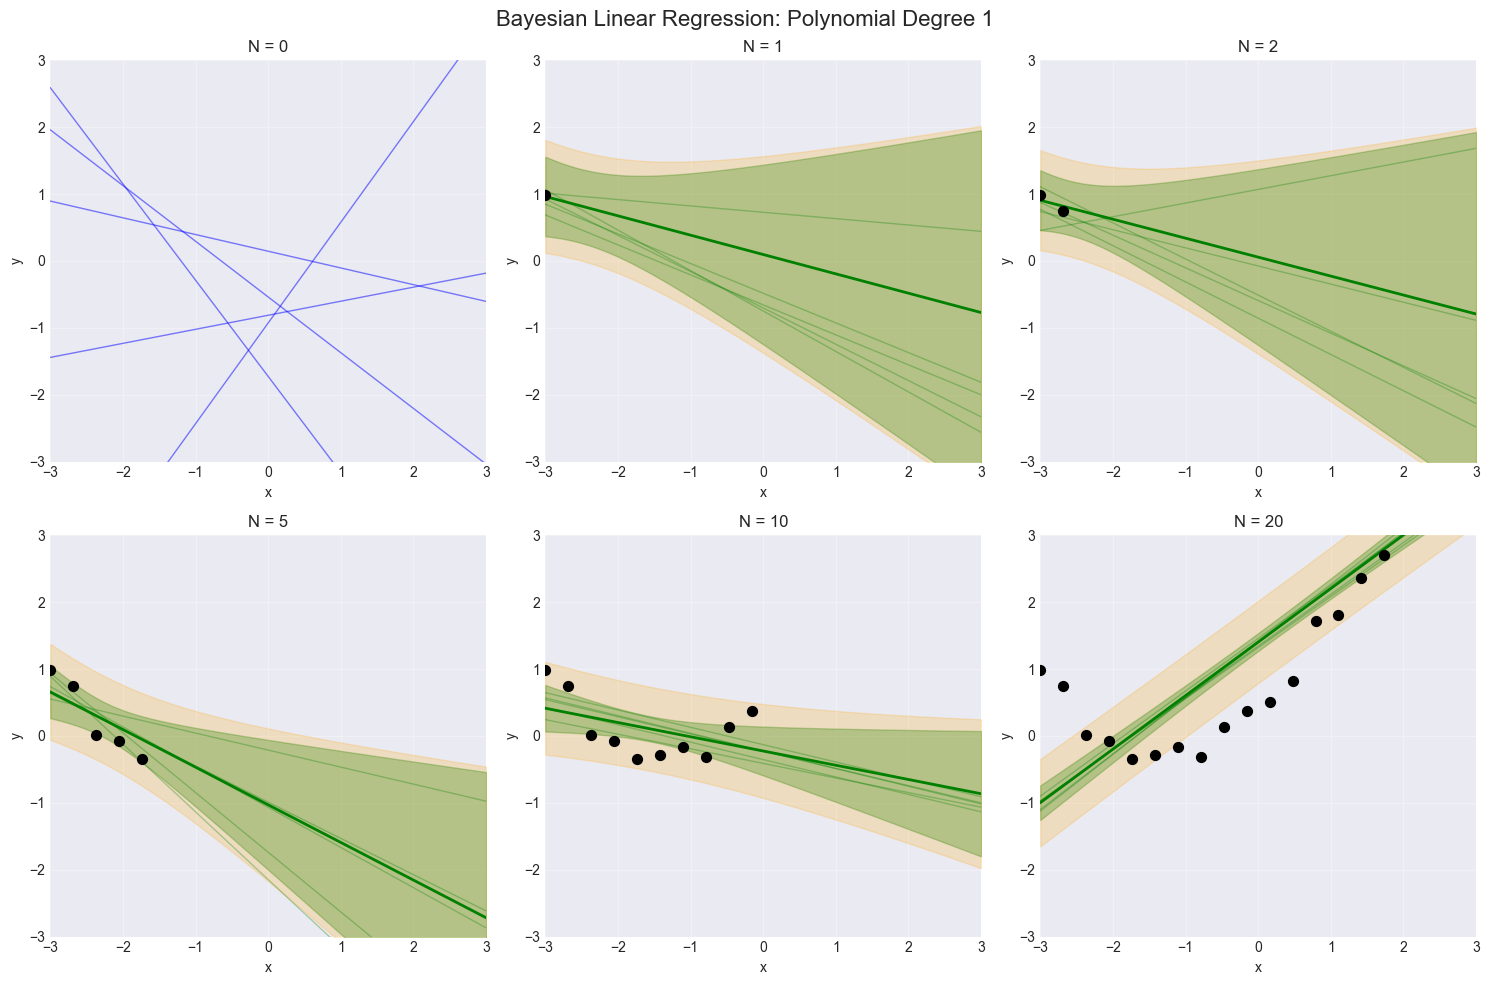


2. Comparing Different Basis Functions


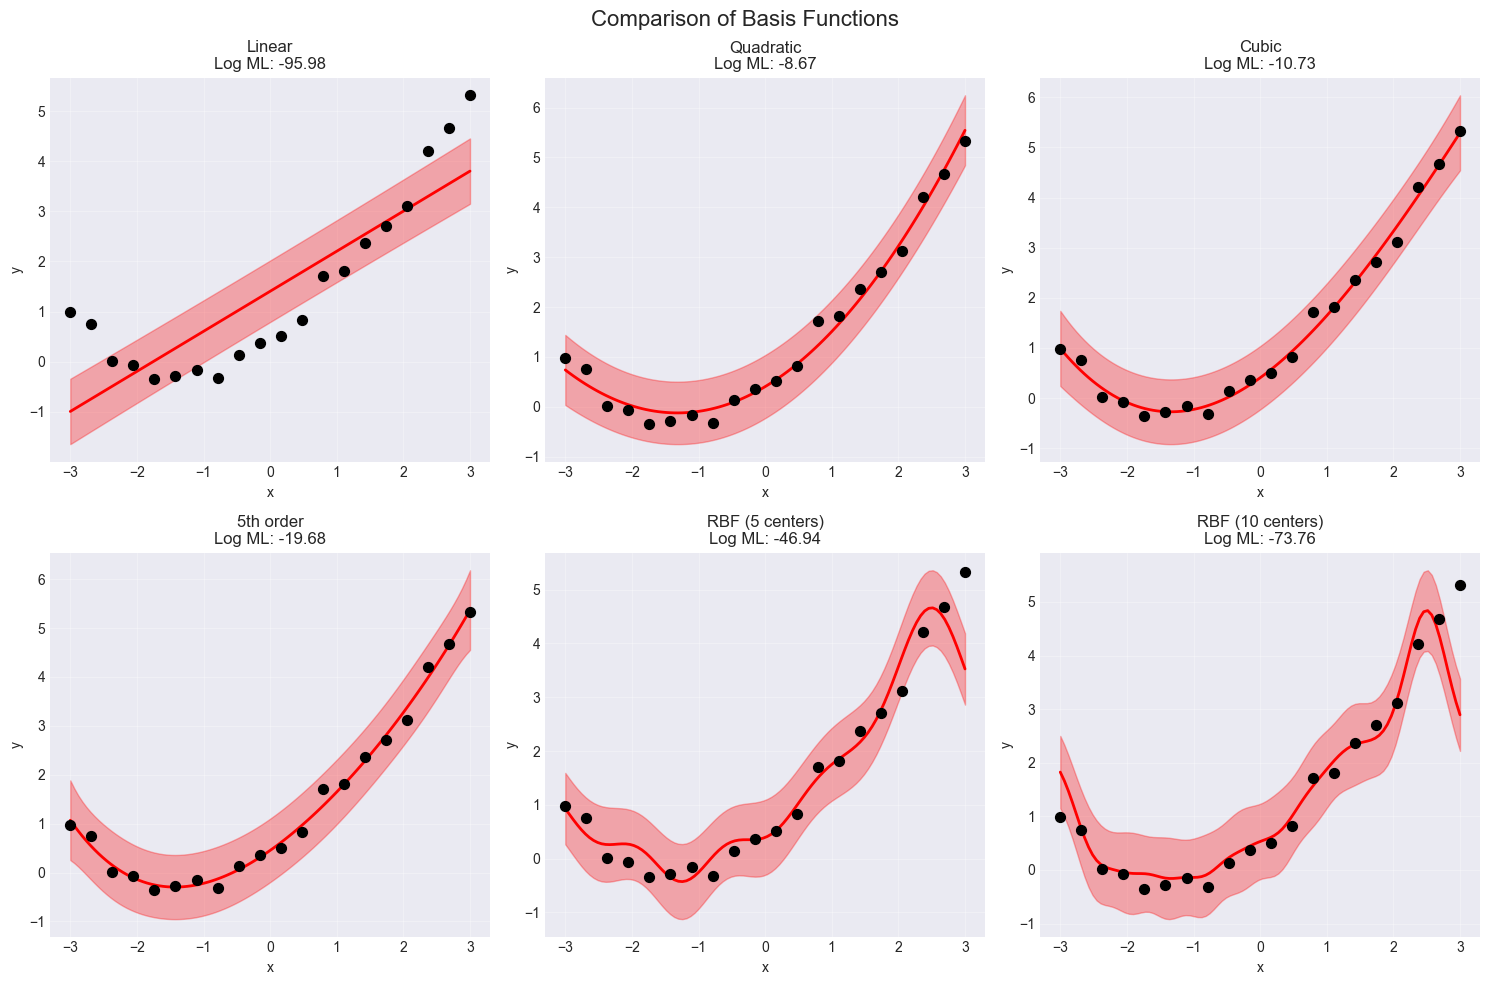


3. Hyperparameter Optimization


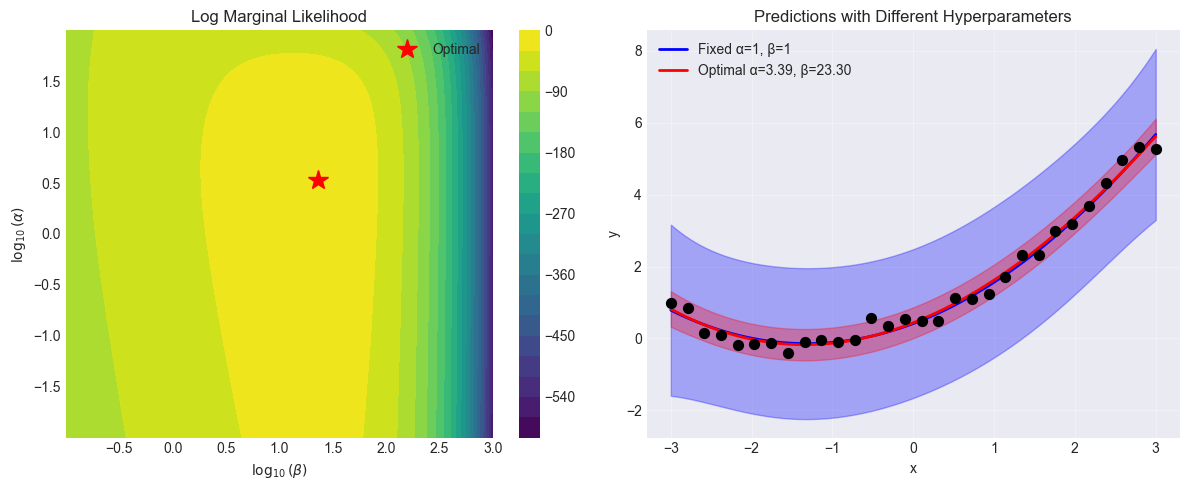

Optimal hyperparameters:
α = 3.3932
β = 23.2995
σ² = 0.0429 (noise variance)

4. Sequential Bayesian Learning


C:\Users\Petrb\AppData\Local\Temp\ipykernel_95628\2100269242.py:614: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Petrb\AppData\Local\Temp\ipykernel_95628\2100269242.py:614: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Petrb\miniconda3\envs\02477_Bayes\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Petrb\miniconda3\envs\02477_Bayes\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


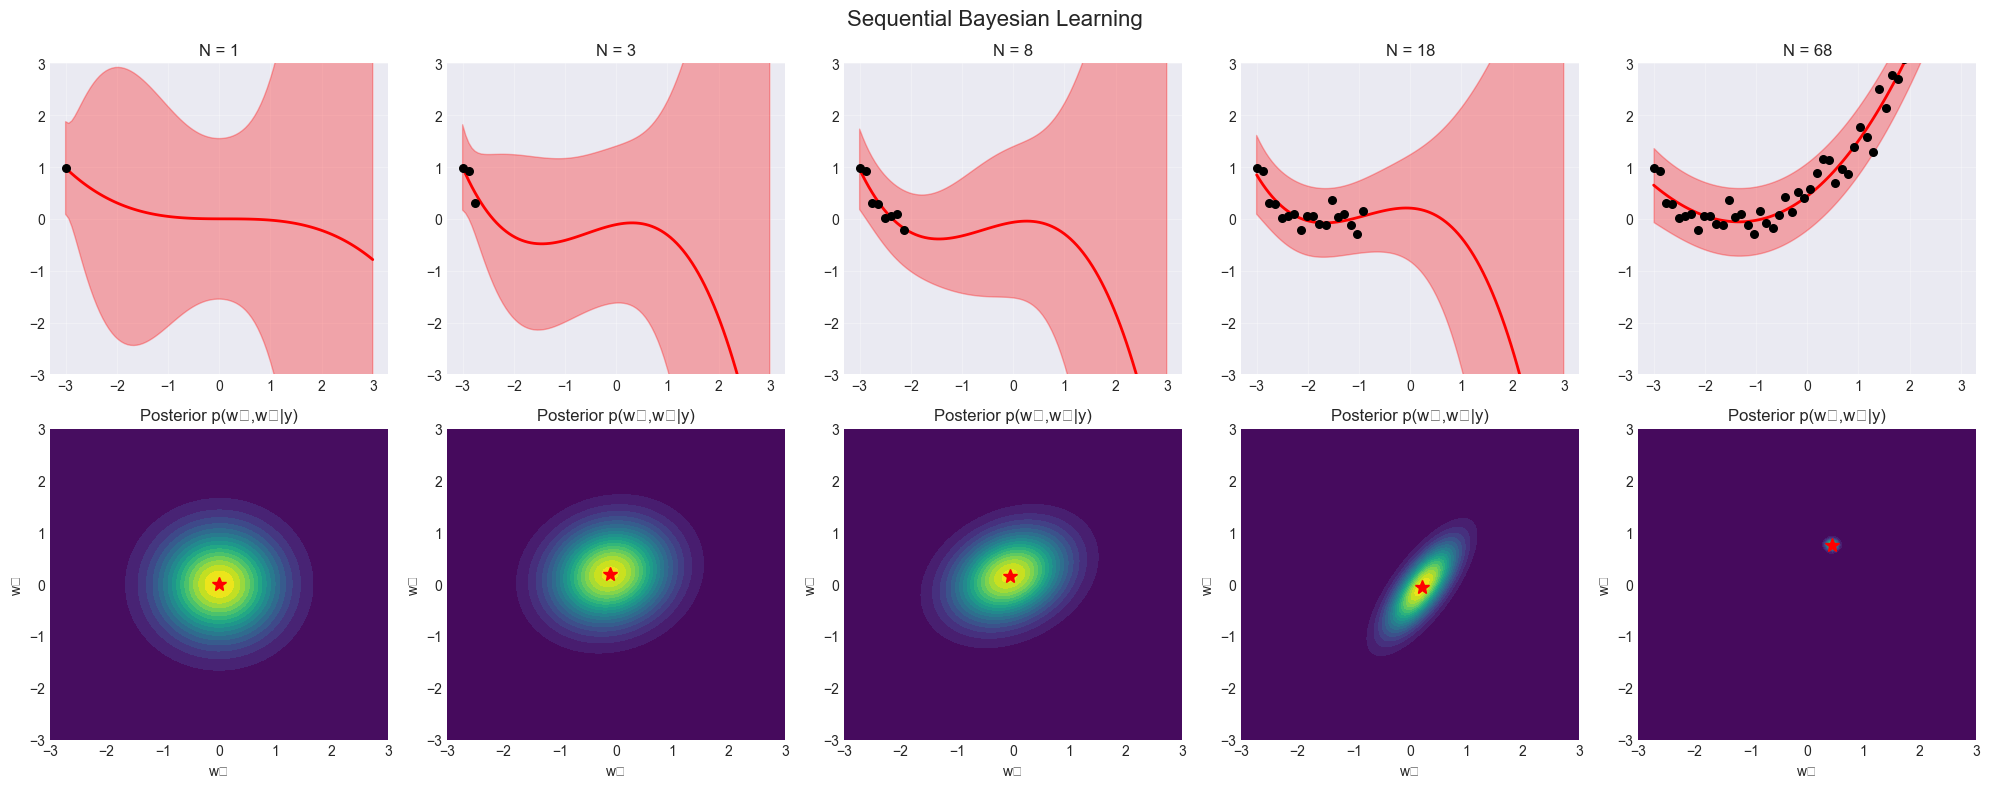

In [1]:
# Bayesian Linear Regression: Theory and Implementation

import numpy as np
import jax
import jax.numpy as jnp
from jax import random, vmap, jit
from jax.scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import minimize
from jax import value_and_grad

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class BayesianLinearRegression:
    """
    Complete implementation of Bayesian Linear Regression
    
    Model: y = Φw + ε
    Prior: w ~ N(m0, S0)
    Noise: ε ~ N(0, β^(-1)I)
    
    Posterior: w|y ~ N(m, S)
    where:
        S = (S0^(-1) + βΦ^TΦ)^(-1)
        m = S(S0^(-1)m0 + βΦ^Ty)
    """
    
    def __init__(self, Phi, y, alpha=1.0, beta=1.0, m0=None, S0=None):
        """
        Initialize Bayesian Linear Regression model
        
        Args:
            Phi: Design matrix, shape (N, D)
            y: Target values, shape (N, 1)
            alpha: Prior precision (inverse variance) for weights
            beta: Noise precision (inverse variance)
            m0: Prior mean, shape (D, 1) [optional]
            S0: Prior covariance, shape (D, D) [optional]
        """
        self.Phi = jnp.array(Phi)
        self.y = jnp.array(y).reshape(-1, 1)
        self.N, self.D = Phi.shape
        self.alpha = alpha
        self.beta = beta
        
        # Set prior parameters
        if m0 is None:
            self.m0 = jnp.zeros((self.D, 1))
        else:
            self.m0 = jnp.array(m0).reshape(-1, 1)
            
        if S0 is None:
            self.S0 = (1/alpha) * jnp.eye(self.D)
        else:
            self.S0 = jnp.array(S0)
        
        # Compute posterior
        self.m, self.S = self.compute_posterior()
        self.S0_inv = jnp.linalg.inv(self.S0)
        
        # Compute log marginal likelihood
        self.log_marginal_likelihood = self.compute_marginal_likelihood()
        
        # Sanity checks
        self._check_dimensions()
    
    def _check_dimensions(self):
        """Verify dimensions are correct"""
        assert self.y.shape == (self.N, 1), f"y shape should be ({self.N}, 1), got {self.y.shape}"
        assert self.m.shape == (self.D, 1), f"m shape should be ({self.D}, 1), got {self.m.shape}"
        assert self.S.shape == (self.D, self.D), f"S shape should be ({self.D}, {self.D}), got {self.S.shape}"
    
    def compute_posterior(self):
        """
        Compute posterior distribution parameters
        
        Returns:
            m: Posterior mean, shape (D, 1)
            S: Posterior covariance, shape (D, D)
        """
        # S = (S0^{-1} + β*Φ^T*Φ)^{-1}
        S0_inv = jnp.linalg.inv(self.S0)
        S_inv = S0_inv + self.beta * self.Phi.T @ self.Phi
        S = jnp.linalg.inv(S_inv)
        
        # m = S*(S0^{-1}*m0 + β*Φ^T*y)
        m = S @ (S0_inv @ self.m0 + self.beta * self.Phi.T @ self.y)
        
        return m, S
    
    def compute_marginal_likelihood(self):
        """
        Compute log marginal likelihood log p(y|α,β)
        
        Using Bishop's formula (3.86):
        log p(y) = (D/2)log α + (N/2)log β - E(m) - (1/2)log|A| - (N/2)log(2π)
        """
        # Prior precision matrix
        S0_inv = jnp.linalg.inv(self.S0)
        
        # A = S0^{-1} + β*Φ^T*Φ (posterior precision)
        A = S0_inv + self.beta * self.Phi.T @ self.Phi
        
        # Energy term E(m) = (β/2)||y - Φm||² + (α/2)||m||²
        residual = self.y - self.Phi @ self.m
        Em = (self.beta/2) * jnp.sum(residual**2) + (self.alpha/2) * jnp.sum(self.m**2)
        
        # Log determinant of A
        sign, logdet = jnp.linalg.slogdet(A)
        
        log_ml = (self.D/2) * jnp.log(self.alpha) + \
                 (self.N/2) * jnp.log(self.beta) - \
                 Em - 0.5 * logdet - \
                 (self.N/2) * jnp.log(2 * jnp.pi)
        
        return log_ml
    
    def predict_f(self, Phi_test):
        """
        Predict function values f* = Φ*w (noise-free)
        
        Args:
            Phi_test: Test design matrix, shape (N*, D)
            
        Returns:
            mu_f: Mean predictions, shape (N*,)
            var_f: Variance of predictions, shape (N*,)
        """
        # μ_f = Φ*m
        mu_f = (Phi_test @ self.m).ravel()
        
        # var_f = diag(Φ*SΦ*^T)
        var_f = jnp.diag(Phi_test @ self.S @ Phi_test.T)
        
        return mu_f, var_f
    
    def predict_y(self, Phi_test):
        """
        Predict observations y* = f* + ε (with noise)
        
        Args:
            Phi_test: Test design matrix, shape (N*, D)
            
        Returns:
            mu_y: Mean predictions, shape (N*,)
            var_y: Variance of predictions, shape (N*,)
        """
        mu_f, var_f = self.predict_f(Phi_test)
        
        # Add noise variance
        mu_y = mu_f
        var_y = var_f + 1/self.beta
        
        return mu_y, var_y
    
    def sample_posterior(self, key, num_samples):
        """
        Sample from posterior distribution
        
        Args:
            key: JAX random key
            num_samples: Number of samples to generate
            
        Returns:
            samples: Weight samples, shape (num_samples, D)
        """
        mean = self.m.ravel()
        samples = random.multivariate_normal(key, mean, self.S, shape=(num_samples,))
        return samples
    
    def sample_prior(self, key, num_samples):
        """
        Sample from prior distribution
        
        Args:
            key: JAX random key
            num_samples: Number of samples to generate
            
        Returns:
            samples: Weight samples, shape (num_samples, D)
        """
        mean = self.m0.ravel()
        samples = random.multivariate_normal(key, mean, self.S0, shape=(num_samples,))
        return samples
    
    def optimize_hyperparameters(self, method='marginal_likelihood'):
        """
        Optimize hyperparameters α and β
        
        Args:
            method: 'marginal_likelihood' or 'cross_validation'
        """
        if method == 'marginal_likelihood':
            # Initial values in log space
            theta0 = jnp.array([jnp.log(self.alpha), jnp.log(self.beta)])
            
            def neg_log_ml(theta):
                alpha, beta = jnp.exp(theta)
                model = BayesianLinearRegression(self.Phi, self.y, alpha=alpha, beta=beta)
                return -model.log_marginal_likelihood
            
            # Optimize
            result = minimize(value_and_grad(neg_log_ml), theta0, jac=True)
            
            # Update hyperparameters
            self.alpha, self.beta = jnp.exp(result.x)
            self.m, self.S = self.compute_posterior()
            self.log_marginal_likelihood = self.compute_marginal_likelihood()
            
            return self.alpha, self.beta
        else:
            raise NotImplementedError("Only marginal likelihood optimization implemented")


def polynomial_basis(x, degree):
    """
    Create polynomial basis functions
    
    Args:
        x: Input values, shape (N, 1)
        degree: Polynomial degree
        
    Returns:
        Phi: Design matrix, shape (N, degree+1)
    """
    x = x.ravel()
    Phi = jnp.column_stack([x**i for i in range(degree + 1)])
    return Phi


def rbf_basis(x, centers, width):
    """
    Create RBF (Gaussian) basis functions
    
    Args:
        x: Input values, shape (N, 1)
        centers: RBF centers, shape (M,)
        width: RBF width parameter
        
    Returns:
        Phi: Design matrix, shape (N, M+1)
    """
    x = x.ravel()
    # Add constant term
    Phi = [jnp.ones_like(x)]
    
    # Add RBF terms
    for c in centers:
        rbf = jnp.exp(-0.5 * ((x - c) / width)**2)
        Phi.append(rbf)
    
    return jnp.column_stack(Phi)


def generate_synthetic_data(n_points=20, noise_std=0.3, seed=42):
    """Generate synthetic data for demonstration"""
    key = random.PRNGKey(seed)
    
    # Input points
    x = jnp.linspace(-3, 3, n_points).reshape(-1, 1)
    
    # True function: y = 0.5 + 0.8*x - 0.3*x^2
    y_true = 0.5 + 0.8 * x + 0.3 * x**2
    
    # Add noise
    key, noise_key = random.split(key)
    noise = noise_std * random.normal(noise_key, shape=y_true.shape)
    y = y_true + noise
    
    return x, y, y_true


def visualize_posterior_evolution(n_points_list=[0, 1, 2, 5, 10, 20], degree=1):
    """Visualize how posterior evolves with more data"""
    
    # Generate full dataset
    x_all, y_all, y_true_all = generate_synthetic_data(n_points=20)
    
    # Test points for predictions
    x_test = jnp.linspace(-3, 3, 100).reshape(-1, 1)
    
    # Hyperparameters
    alpha = 2.0  # Prior precision
    beta = 1/0.3**2  # Noise precision (known)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    key = random.PRNGKey(0)
    
    for idx, n in enumerate(n_points_list):
        ax = axes[idx]
        
        # Use first n points
        if n > 0:
            x_train = x_all[:n]
            y_train = y_all[:n]
            
            # Create design matrices
            Phi_train = polynomial_basis(x_train, degree)
            Phi_test = polynomial_basis(x_test, degree)
            
            # Fit model
            model = BayesianLinearRegression(Phi_train, y_train, alpha=alpha, beta=beta)
            
            # Predictions
            mu_f, var_f = model.predict_f(Phi_test)
            mu_y, var_y = model.predict_y(Phi_test)
            
            # Plot data
            ax.scatter(x_train, y_train, c='black', s=50, zorder=3, label='Data')
            
            # Plot predictions
            ax.plot(x_test, mu_f, 'g-', linewidth=2, label='Mean prediction')
            
            # Confidence intervals
            std_f = jnp.sqrt(var_f)
            std_y = jnp.sqrt(var_y)
            
            ax.fill_between(x_test.ravel(), 
                          mu_f - 2*std_f, 
                          mu_f + 2*std_f,
                          alpha=0.3, color='green', label='Function uncertainty')
            
            ax.fill_between(x_test.ravel(),
                          mu_y - 2*std_y,
                          mu_y + 2*std_y,
                          alpha=0.2, color='orange', label='Predictive uncertainty')
            
            # Sample functions from posterior
            key, sample_key = random.split(key)
            w_samples = model.sample_posterior(sample_key, 5)
            
            for w in w_samples:
                y_sample = Phi_test @ w
                ax.plot(x_test, y_sample, 'g-', alpha=0.3, linewidth=1)
        
        else:
            # Prior only
            Phi_test = polynomial_basis(x_test, degree)
            
            # Sample from prior
            D = degree + 1
            m0 = jnp.zeros(D)
            S0 = (1/alpha) * jnp.eye(D)
            
            key, sample_key = random.split(key)
            w_samples = random.multivariate_normal(sample_key, m0, S0, shape=(5,))
            
            for w in w_samples:
                y_sample = Phi_test @ w
                ax.plot(x_test, y_sample, 'b-', alpha=0.5, linewidth=1)
            
            ax.set_title('Prior (no data)')
        
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f'N = {n}')
        ax.grid(True, alpha=0.3)
        
        if idx == 0:
            ax.legend()
    
    plt.suptitle(f'Bayesian Linear Regression: Polynomial Degree {degree}', fontsize=16)
    plt.tight_layout()
    plt.show()


def compare_basis_functions():
    """Compare different basis function choices"""
    
    # Generate data
    x_train, y_train, _ = generate_synthetic_data(n_points=20)
    x_test = jnp.linspace(-3, 3, 100).reshape(-1, 1)
    
    # Hyperparameters
    alpha = 2.0
    beta = 1/0.3**2
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Different basis functions
    basis_functions = [
        ('Linear', polynomial_basis, {'degree': 1}),
        ('Quadratic', polynomial_basis, {'degree': 2}),
        ('Cubic', polynomial_basis, {'degree': 3}),
        ('5th order', polynomial_basis, {'degree': 5}),
        ('RBF (5 centers)', rbf_basis, 
         {'centers': jnp.linspace(-2.5, 2.5, 5), 'width': 0.5}),
        ('RBF (10 centers)', rbf_basis,
         {'centers': jnp.linspace(-2.5, 2.5, 10), 'width': 0.3})
    ]
    
    for idx, (name, basis_func, params) in enumerate(basis_functions):
        ax = axes[idx // 3, idx % 3]
        
        # Create design matrices
        if basis_func == polynomial_basis:
            Phi_train = basis_func(x_train, **params)
            Phi_test = basis_func(x_test, **params)
        else:
            Phi_train = basis_func(x_train, **params)
            Phi_test = basis_func(x_test, **params)
        
        # Fit model
        model = BayesianLinearRegression(Phi_train, y_train, alpha=alpha, beta=beta)
        
        # Predictions
        mu_y, var_y = model.predict_y(Phi_test)
        std_y = jnp.sqrt(var_y)
        
        # Plot
        ax.scatter(x_train, y_train, c='black', s=50, zorder=3)
        ax.plot(x_test, mu_y, 'r-', linewidth=2)
        ax.fill_between(x_test.ravel(),
                       mu_y - 2*std_y,
                       mu_y + 2*std_y,
                       alpha=0.3, color='red')
        
        ax.set_title(f'{name}\nLog ML: {model.log_marginal_likelihood:.2f}')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Comparison of Basis Functions', fontsize=16)
    plt.tight_layout()
    plt.show()


def hyperparameter_optimization_demo():
    """Demonstrate hyperparameter optimization"""
    
    # Generate data
    x_train, y_train, _ = generate_synthetic_data(n_points=30, noise_std=0.3)
    
    # Create design matrix (polynomial)
    degree = 3
    Phi_train = polynomial_basis(x_train, degree)
    
    # Grid search over hyperparameters
    alpha_range = jnp.logspace(-2, 2, 50)
    beta_range = jnp.logspace(-1, 3, 50)
    
    log_ml_grid = jnp.zeros((len(alpha_range), len(beta_range)))
    
    for i, alpha in enumerate(alpha_range):
        for j, beta in enumerate(beta_range):
            model = BayesianLinearRegression(Phi_train, y_train, 
                                           alpha=alpha, beta=beta)
            log_ml_grid = log_ml_grid.at[i, j].set(model.log_marginal_likelihood)
    
    # Find optimal values
    i_opt, j_opt = jnp.unravel_index(jnp.argmax(log_ml_grid), log_ml_grid.shape)
    alpha_opt = alpha_range[i_opt]
    beta_opt = beta_range[j_opt]
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Contour plot of log marginal likelihood
    im = ax1.contourf(jnp.log10(beta_range), jnp.log10(alpha_range), 
                     log_ml_grid, levels=20, cmap='viridis')
    ax1.plot(jnp.log10(beta_opt), jnp.log10(alpha_opt), 'r*', 
            markersize=15, label='Optimal')
    ax1.set_xlabel(r'$\log_{10}(\beta)$')
    ax1.set_ylabel(r'$\log_{10}(\alpha)$')
    ax1.set_title('Log Marginal Likelihood')
    plt.colorbar(im, ax=ax1)
    ax1.legend()
    
    # Compare predictions with different hyperparameters
    x_test = jnp.linspace(-3, 3, 100).reshape(-1, 1)
    Phi_test = polynomial_basis(x_test, degree)
    
    # Fixed hyperparameters
    model_fixed = BayesianLinearRegression(Phi_train, y_train, 
                                         alpha=1.0, beta=1.0)
    mu_fixed, var_fixed = model_fixed.predict_y(Phi_test)
    
    # Optimized hyperparameters
    model_opt = BayesianLinearRegression(Phi_train, y_train,
                                       alpha=alpha_opt, beta=beta_opt)
    mu_opt, var_opt = model_opt.predict_y(Phi_test)
    
    ax2.scatter(x_train, y_train, c='black', s=50, zorder=3)
    
    # Fixed hyperparameters
    ax2.plot(x_test, mu_fixed, 'b-', linewidth=2, label='Fixed α=1, β=1')
    ax2.fill_between(x_test.ravel(),
                    mu_fixed - 2*jnp.sqrt(var_fixed),
                    mu_fixed + 2*jnp.sqrt(var_fixed),
                    alpha=0.3, color='blue')
    
    # Optimized hyperparameters
    ax2.plot(x_test, mu_opt, 'r-', linewidth=2, 
            label=f'Optimal α={alpha_opt:.2f}, β={beta_opt:.2f}')
    ax2.fill_between(x_test.ravel(),
                    mu_opt - 2*jnp.sqrt(var_opt),
                    mu_opt + 2*jnp.sqrt(var_opt),
                    alpha=0.3, color='red')
    
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title('Predictions with Different Hyperparameters')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print results
    print(f"Optimal hyperparameters:")
    print(f"α = {alpha_opt:.4f}")
    print(f"β = {beta_opt:.4f}")
    print(f"σ² = {1/beta_opt:.4f} (noise variance)")


def sequential_learning_demo():
    """Demonstrate sequential Bayesian learning"""
    
    # Generate data
    x_all, y_all, _ = generate_synthetic_data(n_points=50)
    
    # Test points
    x_test = jnp.linspace(-3, 3, 100).reshape(-1, 1)
    
    # Hyperparameters
    alpha = 2.0
    beta = 10.0
    
    # Basis function
    degree = 3
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    
    # Sequential updates
    batch_sizes = [1, 2, 5, 10, 50]
    n_total = 0
    
    # Initial model (prior only)
    D = degree + 1
    m = jnp.zeros((D, 1))
    S = (1/alpha) * jnp.eye(D)
    
    for idx, batch_size in enumerate(batch_sizes):
        # Get next batch of data
        n_new = n_total + batch_size
        x_batch = x_all[n_total:n_new]
        y_batch = y_all[n_total:n_new]
        
        if batch_size > 0:
            # Update with new data
            Phi_batch = polynomial_basis(x_batch, degree)
            
            # Sequential update formulas
            S_inv_new = jnp.linalg.inv(S) + beta * Phi_batch.T @ Phi_batch
            S_new = jnp.linalg.inv(S_inv_new)
            m_new = S_new @ (jnp.linalg.inv(S) @ m + beta * Phi_batch.T @ y_batch)
            
            m, S = m_new, S_new
        
        # Predictions
        Phi_test = polynomial_basis(x_test, degree)
        mu_f = (Phi_test @ m).ravel()
        var_f = jnp.diag(Phi_test @ S @ Phi_test.T)
        mu_y = mu_f
        var_y = var_f + 1/beta
        
        # Plot in data space
        ax = axes[0, idx]
        if n_new > 0:
            ax.scatter(x_all[:n_new], y_all[:n_new], c='black', s=30, zorder=3)
        ax.plot(x_test, mu_y, 'r-', linewidth=2)
        ax.fill_between(x_test.ravel(),
                       mu_y - 2*jnp.sqrt(var_y),
                       mu_y + 2*jnp.sqrt(var_y),
                       alpha=0.3, color='red')
        ax.set_title(f'N = {n_new}')
        ax.set_ylim(-3, 3)
        ax.grid(True, alpha=0.3)
        
        # Plot in weight space (first two dimensions)
        ax2 = axes[1, idx]
        
        # Create grid for weight space
        w0_range = jnp.linspace(-3, 3, 100)
        w1_range = jnp.linspace(-3, 3, 100)
        W0, W1 = jnp.meshgrid(w0_range, w1_range)
        W_grid = jnp.stack([W0.ravel(), W1.ravel()], axis=1)
        
        # Evaluate posterior on grid (2D marginal)
        m_2d = m[:2].ravel()
        S_2d = S[:2, :2]
        
        log_prob = multivariate_normal.logpdf(W_grid, m_2d, S_2d)
        prob = jnp.exp(log_prob).reshape(W0.shape)
        
        ax2.contourf(W0, W1, prob, levels=20, cmap='viridis')
        ax2.plot(m[0], m[1], 'r*', markersize=10)
        ax2.set_xlabel('w₀')
        ax2.set_ylabel('w₁')
        ax2.set_title('Posterior p(w₀,w₁|y)')
        ax2.grid(True, alpha=0.3)
        
        n_total = n_new
    
    plt.suptitle('Sequential Bayesian Learning', fontsize=16)
    plt.tight_layout()
    plt.show()


# Main execution
if __name__ == "__main__":
    print("=== Bayesian Linear Regression Demo ===")
    
    # 1. Basic evolution of posterior
    print("\n1. Posterior Evolution with Data")
    visualize_posterior_evolution()
    
    # 2. Compare basis functions
    print("\n2. Comparing Different Basis Functions")
    compare_basis_functions()
    
    # 3. Hyperparameter optimization
    print("\n3. Hyperparameter Optimization")
    hyperparameter_optimization_demo()
    
    # 4. Sequential learning
    print("\n4. Sequential Bayesian Learning")
    sequential_learning_demo()

BAYESIAN LINEAR REGRESSION: DETAILED EXAMPLES
=== Hand Calculation Example ===
Simple linear model: y = a + bx + ε
Prior: w ~ N(0, α⁻¹I)
Noise: ε ~ N(0, β⁻¹)

Data:
x = [0 1 2]
y = [1.  2.  2.5]

Design matrix Φ:
[[1 0]
 [1 1]
 [1 2]]

Hyperparameters:
α = 1.0 (prior precision)
β = 4.0 (noise precision)
σ² = 0.250 (noise variance)

Prior:
m₀ = [0. 0.]
S₀ = 
[[1. 0.]
 [0. 1.]]

ΦᵀΦ = 
[[3 3]
 [3 5]]

S⁻¹ = S₀⁻¹ + βΦᵀΦ = 
[[13. 12.]
 [12. 21.]]

S = (S⁻¹)⁻¹ = 
[[ 0.1627907  -0.09302326]
 [-0.09302326  0.10077519]]

Φᵀy = [5.5 7. ]

Posterior mean m = S(S₀⁻¹m₀ + βΦᵀy) = [0.97674419 0.7751938 ]

Interpretation:
Estimated model: y = 0.977 + 0.775x

Uncertainty (std dev):
σ_a = 0.403
σ_b = 0.317

95% Credible Intervals:
a: [0.186, 1.768]
b: [0.153, 1.397]

Prediction at x* = 1.5:
Mean: 2.140
Function variance: 0.110
Predictive variance: 0.360
95% prediction interval: [0.963, 3.316]


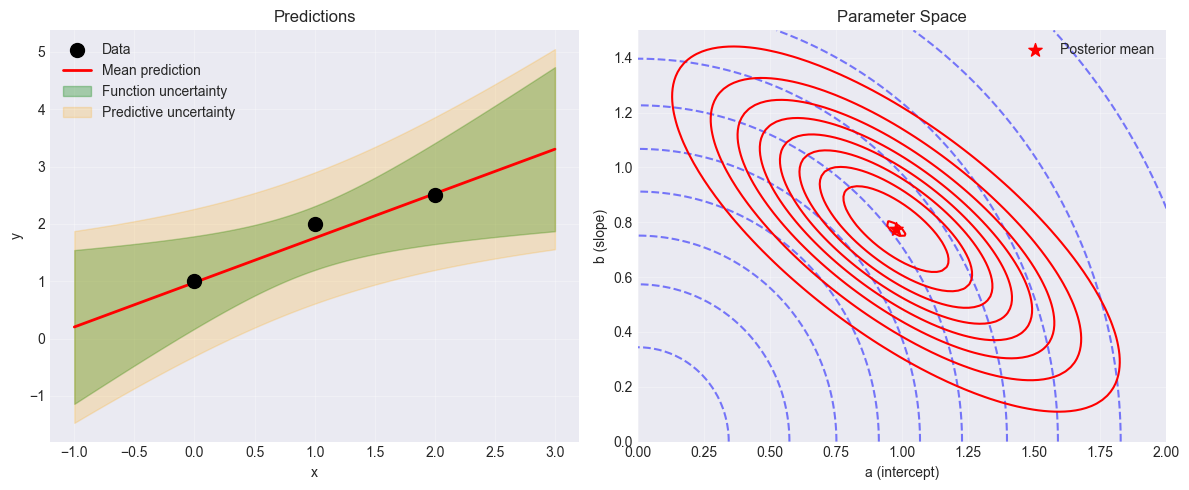


=== Sequential Update Example ===

Batch 1: x=[0], y=[0.5]
Updated mean: [0.35714286 0.        ]
Updated covariance:
[[0.14285714 0.        ]
 [0.         0.5       ]]

Batch 2: x=[1], y=[1.8]
Updated mean: [0.60169492 0.8559322 ]
Updated covariance:
[[ 0.11864407 -0.08474576]
 [-0.08474576  0.20338983]]

Batch 3: x=[2 3], y=[2.5 3.2]
Updated mean: [0.61403509 0.88304094]
Updated covariance:
[[ 0.10526316 -0.04385965]
 [-0.04385965  0.03216374]]


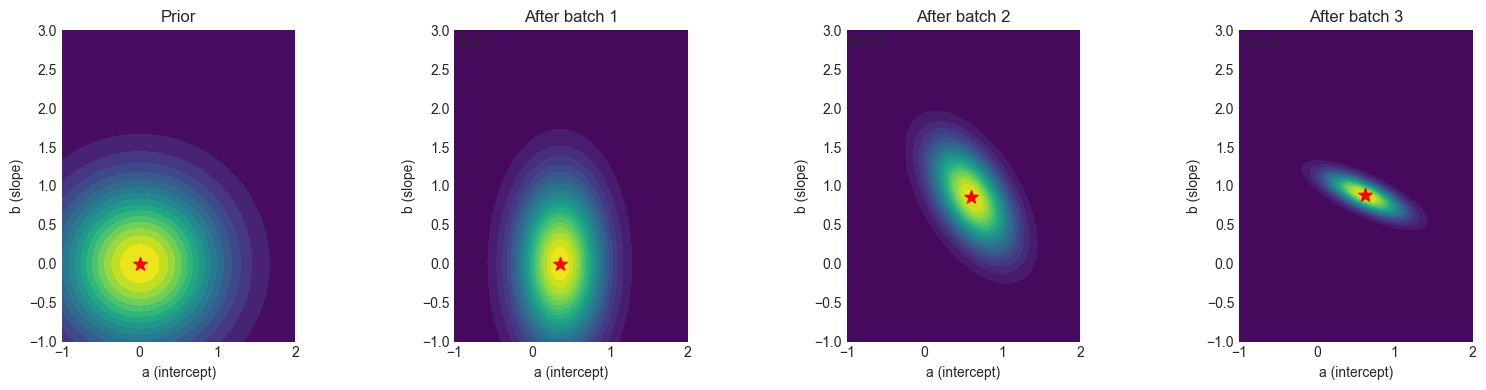

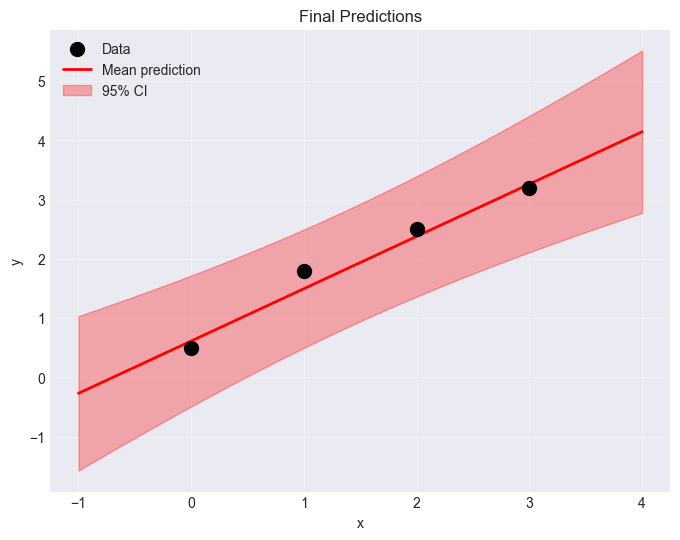


=== Model Selection Example ===
Degree 1: log ML = -18.234
Degree 2: log ML = -8.456
Degree 3: log ML = -5.854
Degree 4: log ML = -8.543
Degree 5: log ML = -11.252
Degree 6: log ML = -14.064
Degree 7: log ML = -16.938

Best polynomial degree: 3


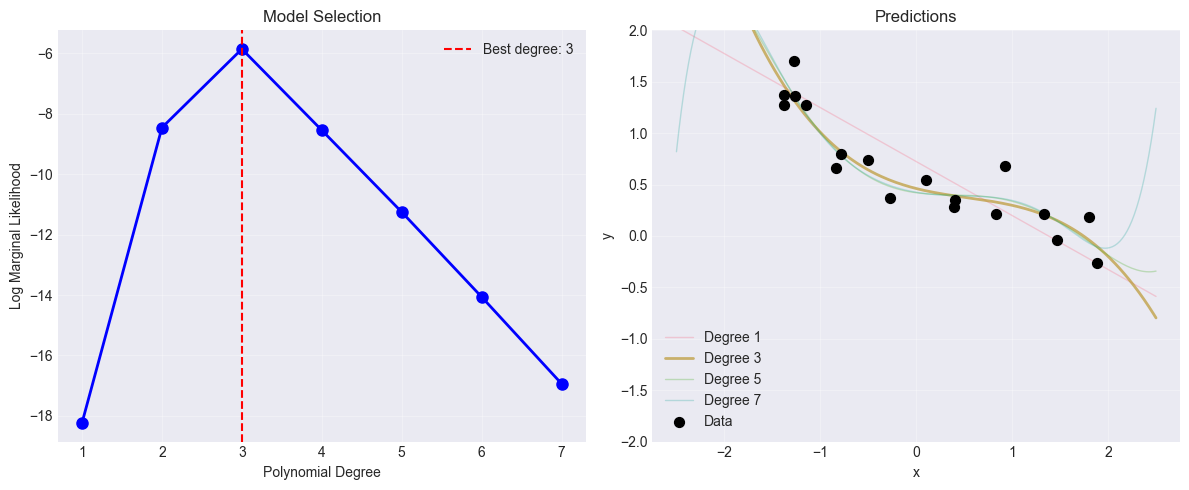


=== Hyperparameter Sensitivity ===


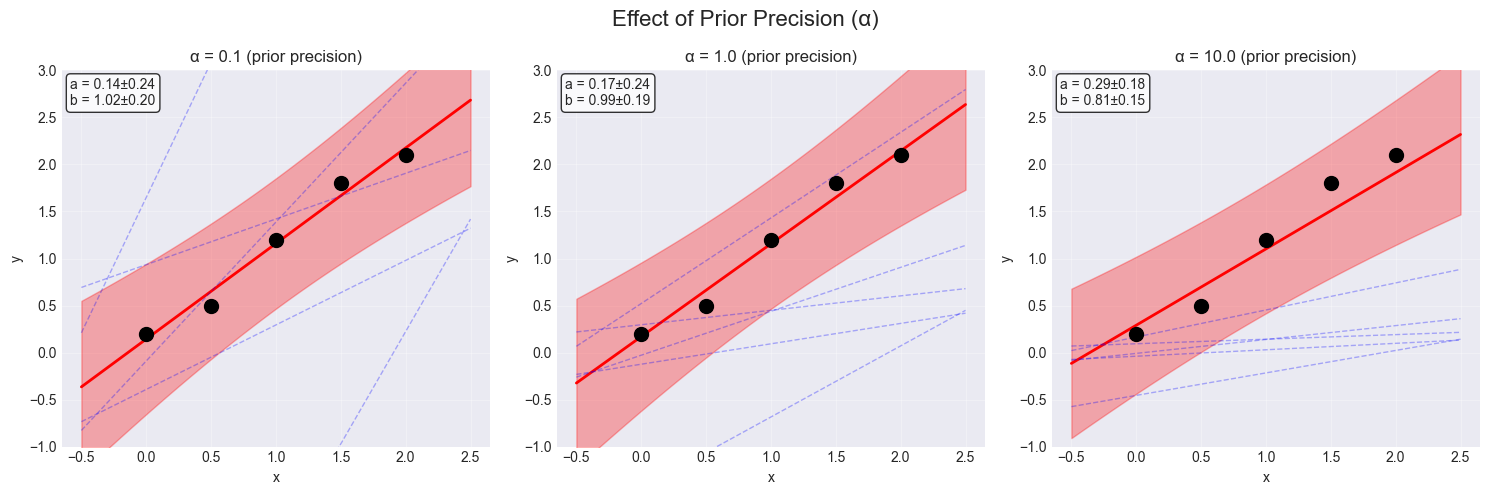

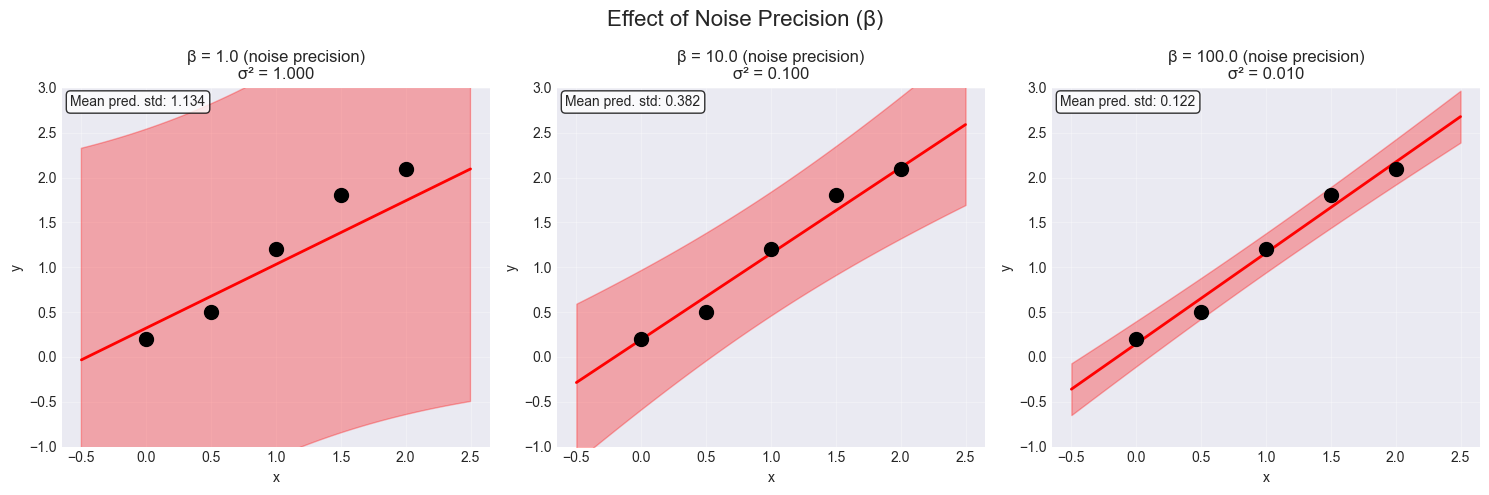


All examples completed!


In [3]:
# Bayesian Linear Regression: Detailed Practical Example

import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class DetailedBayesianLinearRegressionExample:
    """
    Complete walkthrough of Bayesian Linear Regression
    with hand calculations and visualizations
    """
    
    def __init__(self):
        self.seed = 42
        np.random.seed(self.seed)
    
    def simple_hand_calculation(self):
        """
        Hand calculation example with minimal data
        """
        print("=== Hand Calculation Example ===")
        print("Simple linear model: y = a + bx + ε")
        print("Prior: w ~ N(0, α⁻¹I)")
        print("Noise: ε ~ N(0, β⁻¹)")
        
        # Data: 3 points
        x = np.array([0, 1, 2])
        y = np.array([1, 2, 2.5])
        
        # Design matrix Φ = [1, x]
        Phi = np.column_stack([np.ones_like(x), x])
        print(f"\nData:")
        print(f"x = {x}")
        print(f"y = {y}")
        print(f"\nDesign matrix Φ:")
        print(Phi)
        
        # Hyperparameters
        alpha = 1.0  # Prior precision
        beta = 4.0   # Noise precision (σ² = 0.25)
        
        print(f"\nHyperparameters:")
        print(f"α = {alpha} (prior precision)")
        print(f"β = {beta} (noise precision)")
        print(f"σ² = {1/beta:.3f} (noise variance)")
        
        # Prior
        m0 = np.zeros(2)
        S0 = (1/alpha) * np.eye(2)
        S0_inv = alpha * np.eye(2)
        
        print(f"\nPrior:")
        print(f"m₀ = {m0}")
        print(f"S₀ = \n{S0}")
        
        # Step 1: Compute Φᵀ Φ
        PhiT_Phi = Phi.T @ Phi
        print(f"\nΦᵀΦ = \n{PhiT_Phi}")
        
        # Step 2: Compute S⁻¹ = S₀⁻¹ + β Φᵀ Φ
        S_inv = S0_inv + beta * PhiT_Phi
        print(f"\nS⁻¹ = S₀⁻¹ + βΦᵀΦ = \n{S_inv}")
        
        # Step 3: Compute S = (S⁻¹)⁻¹
        S = np.linalg.inv(S_inv)
        print(f"\nS = (S⁻¹)⁻¹ = \n{S}")
        
        # Step 4: Compute m = S(S₀⁻¹m₀ + β Φᵀ y)
        PhiT_y = Phi.T @ y
        print(f"\nΦᵀy = {PhiT_y}")
        
        m = S @ (S0_inv @ m0 + beta * PhiT_y)
        print(f"\nPosterior mean m = S(S₀⁻¹m₀ + βΦᵀy) = {m}")
        
        # Interpretation
        print(f"\nInterpretation:")
        print(f"Estimated model: y = {m[0]:.3f} + {m[1]:.3f}x")
        
        # Uncertainty
        std_a = np.sqrt(S[0, 0])
        std_b = np.sqrt(S[1, 1])
        print(f"\nUncertainty (std dev):")
        print(f"σ_a = {std_a:.3f}")
        print(f"σ_b = {std_b:.3f}")
        
        # 95% credible intervals
        ci_a = [m[0] - 1.96*std_a, m[0] + 1.96*std_a]
        ci_b = [m[1] - 1.96*std_b, m[1] + 1.96*std_b]
        print(f"\n95% Credible Intervals:")
        print(f"a: [{ci_a[0]:.3f}, {ci_a[1]:.3f}]")
        print(f"b: [{ci_b[0]:.3f}, {ci_b[1]:.3f}]")
        
        # Prediction at x* = 1.5
        x_star = 1.5
        phi_star = np.array([1, x_star])
        
        # Mean prediction
        mu_star = phi_star @ m
        
        # Variance
        var_f_star = phi_star @ S @ phi_star
        var_y_star = var_f_star + 1/beta
        
        print(f"\nPrediction at x* = {x_star}:")
        print(f"Mean: {mu_star:.3f}")
        print(f"Function variance: {var_f_star:.3f}")
        print(f"Predictive variance: {var_y_star:.3f}")
        print(f"95% prediction interval: [{mu_star - 1.96*np.sqrt(var_y_star):.3f}, "
              f"{mu_star + 1.96*np.sqrt(var_y_star):.3f}]")
        
        # Visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Data and predictions
        x_test = np.linspace(-1, 3, 100)
        Phi_test = np.column_stack([np.ones_like(x_test), x_test])
        
        mu_test = Phi_test @ m
        var_f_test = np.diag(Phi_test @ S @ Phi_test.T)
        var_y_test = var_f_test + 1/beta
        
        ax1.scatter(x, y, s=100, c='black', zorder=3, label='Data')
        ax1.plot(x_test, mu_test, 'r-', linewidth=2, label='Mean prediction')
        ax1.fill_between(x_test, 
                        mu_test - 2*np.sqrt(var_f_test),
                        mu_test + 2*np.sqrt(var_f_test),
                        alpha=0.3, color='green', label='Function uncertainty')
        ax1.fill_between(x_test,
                        mu_test - 2*np.sqrt(var_y_test),
                        mu_test + 2*np.sqrt(var_y_test),
                        alpha=0.2, color='orange', label='Predictive uncertainty')
        
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_title('Predictions')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Weight space
        a_range = np.linspace(0, 2, 100)
        b_range = np.linspace(0, 1.5, 100)
        A, B = np.meshgrid(a_range, b_range)
        
        # Prior
        prior_rv = multivariate_normal(m0, S0)
        pos = np.dstack((A, B))
        prior_density = prior_rv.pdf(pos)
        
        # Posterior
        posterior_rv = multivariate_normal(m, S)
        posterior_density = posterior_rv.pdf(pos)
        
        ax2.contour(A, B, prior_density, levels=10, colors='blue', 
                   linestyles='--', alpha=0.5)
        ax2.contour(A, B, posterior_density, levels=10, colors='red', 
                   linestyles='-')
        ax2.scatter([m[0]], [m[1]], c='red', s=100, marker='*', 
                   zorder=3, label='Posterior mean')
        
        # Add true parameters if known
        # ax2.scatter([true_a], [true_b], c='green', s=100, marker='x', 
        #            zorder=3, label='True values')
        
        ax2.set_xlabel('a (intercept)')
        ax2.set_ylabel('b (slope)')
        ax2.set_title('Parameter Space')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return Phi, y, m, S, alpha, beta
    
    def sequential_update_example(self):
        """
        Demonstrate sequential Bayesian updating
        """
        print("\n=== Sequential Update Example ===")
        
        # Initial hyperparameters
        alpha = 2.0
        beta = 5.0
        
        # Start with prior
        m = np.array([0., 0.])
        S = (1/alpha) * np.eye(2)
        
        # Data arrives in batches
        data_batches = [
            {'x': np.array([0]), 'y': np.array([0.5])},
            {'x': np.array([1]), 'y': np.array([1.8])},
            {'x': np.array([2, 3]), 'y': np.array([2.5, 3.2])},
        ]
        
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        
        # Plot prior
        ax = axes[0]
        self._plot_weight_distribution(ax, m, S, title='Prior')
        
        all_x = []
        all_y = []
        
        for i, batch in enumerate(data_batches):
            print(f"\nBatch {i+1}: x={batch['x']}, y={batch['y']}")
            
            # Create design matrix for new data
            Phi_new = np.column_stack([np.ones_like(batch['x']), batch['x']])
            
            # Sequential update
            S_inv_new = np.linalg.inv(S) + beta * Phi_new.T @ Phi_new
            S_new = np.linalg.inv(S_inv_new)
            m_new = S_new @ (np.linalg.inv(S) @ m + beta * Phi_new.T @ batch['y'])
            
            print(f"Updated mean: {m_new}")
            print(f"Updated covariance:\n{S_new}")
            
            # Store updated parameters
            m, S = m_new, S_new
            
            # Accumulate all data
            all_x.extend(batch['x'])
            all_y.extend(batch['y'])
            
            # Plot updated posterior
            ax = axes[i+1]
            self._plot_weight_distribution(ax, m, S, 
                                         title=f'After batch {i+1}')
            
            # Add data points
            ax.text(0.02, 0.98, f'N = {len(all_x)}', 
                   transform=ax.transAxes, 
                   verticalalignment='top')
        
        plt.tight_layout()
        plt.show()
        
        # Final predictions
        self._plot_final_predictions(np.array(all_x), np.array(all_y), 
                                   m, S, beta)
    
    def _plot_weight_distribution(self, ax, m, S, title=''):
        """Helper to plot weight distribution"""
        # Create grid
        a_range = np.linspace(-1, 2, 100)
        b_range = np.linspace(-1, 3, 100)
        A, B = np.meshgrid(a_range, b_range)
        
        # Compute density
        rv = multivariate_normal(m, S)
        pos = np.dstack((A, B))
        density = rv.pdf(pos)
        
        # Plot
        ax.contourf(A, B, density, levels=20, cmap='viridis')
        ax.scatter([m[0]], [m[1]], c='red', s=100, marker='*')
        ax.set_xlabel('a (intercept)')
        ax.set_ylabel('b (slope)')
        ax.set_title(title)
        ax.set_aspect('equal')
    
    def _plot_final_predictions(self, x, y, m, S, beta):
        """Plot final predictions after sequential updates"""
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Test points
        x_test = np.linspace(-1, 4, 100)
        Phi_test = np.column_stack([np.ones_like(x_test), x_test])
        
        # Predictions
        mu_test = Phi_test @ m
        var_test = np.diag(Phi_test @ S @ Phi_test.T) + 1/beta
        
        # Plot
        ax.scatter(x, y, s=100, c='black', zorder=3, label='Data')
        ax.plot(x_test, mu_test, 'r-', linewidth=2, label='Mean prediction')
        ax.fill_between(x_test,
                       mu_test - 2*np.sqrt(var_test),
                       mu_test + 2*np.sqrt(var_test),
                       alpha=0.3, color='red', label='95% CI')
        
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title('Final Predictions')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.show()
    
    def model_selection_example(self):
        """
        Compare different polynomial degrees using marginal likelihood
        """
        print("\n=== Model Selection Example ===")
        
        # Generate true data from cubic function
        np.random.seed(42)
        n_points = 20
        x = np.sort(np.random.uniform(-2, 2, n_points))
        y_true = 0.5 - 0.3*x + 0.2*x**2 - 0.1*x**3
        y = y_true + 0.2*np.random.randn(n_points)
        
        # Hyperparameters
        alpha = 2.0
        beta = 1/0.2**2  # Known noise variance
        
        # Compare polynomial degrees
        degrees = range(1, 8)
        log_mls = []
        models = []
        
        for degree in degrees:
            # Create design matrix
            Phi = np.column_stack([x**i for i in range(degree+1)])
            
            # Fit model
            model = BayesianLinearRegression(Phi, y.reshape(-1, 1), 
                                           alpha=alpha, beta=beta)
            log_mls.append(model.log_marginal_likelihood)
            models.append(model)
            
            print(f"Degree {degree}: log ML = {model.log_marginal_likelihood:.3f}")
        
        # Find best degree
        best_degree = degrees[np.argmax(log_mls)]
        print(f"\nBest polynomial degree: {best_degree}")
        
        # Visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Log marginal likelihood
        ax1.plot(degrees, log_mls, 'b-o', linewidth=2, markersize=8)
        ax1.axvline(best_degree, color='red', linestyle='--', 
                   label=f'Best degree: {best_degree}')
        ax1.set_xlabel('Polynomial Degree')
        ax1.set_ylabel('Log Marginal Likelihood')
        ax1.set_title('Model Selection')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Predictions for different degrees
        x_test = np.linspace(-2.5, 2.5, 200)
        
        for i, degree in enumerate([1, 3, 5, 7]):
            model = models[degree-1]
            Phi_test = np.column_stack([x_test**j for j in range(degree+1)])
            mu_test, var_test = model.predict_y(Phi_test)
            
            alpha_val = 0.7 if degree == best_degree else 0.3
            linewidth = 2 if degree == best_degree else 1
            
            ax2.plot(x_test, mu_test, 
                    label=f'Degree {degree}',
                    alpha=alpha_val,
                    linewidth=linewidth)
        
        ax2.scatter(x, y, s=50, c='black', zorder=3, label='Data')
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_title('Predictions')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(-2, 2)
        
        plt.tight_layout()
        plt.show()
    
    def hyperparameter_sensitivity(self):
        """
        Show how predictions change with different hyperparameters
        """
        print("\n=== Hyperparameter Sensitivity ===")
        
        # Simple dataset
        x = np.array([0, 0.5, 1, 1.5, 2])
        y = np.array([0.2, 0.5, 1.2, 1.8, 2.1])
        
        # Design matrix
        Phi = np.column_stack([np.ones_like(x), x])
        
        # Test different alpha values (prior precision)
        alphas = [0.1, 1.0, 10.0]
        beta = 10.0  # Fixed noise precision
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        x_test = np.linspace(-0.5, 2.5, 100)
        Phi_test = np.column_stack([np.ones_like(x_test), x_test])
        
        for i, alpha in enumerate(alphas):
            ax = axes[i]
            
            # Fit model
            model = BayesianLinearRegression(Phi, y.reshape(-1, 1),
                                           alpha=alpha, beta=beta)
            
            # Predictions
            mu_test, var_test = model.predict_y(Phi_test)
            std_test = np.sqrt(var_test)
            
            # Plot
            ax.scatter(x, y, s=100, c='black', zorder=3)
            ax.plot(x_test, mu_test, 'r-', linewidth=2)
            ax.fill_between(x_test,
                          mu_test - 2*std_test,
                          mu_test + 2*std_test,
                          alpha=0.3, color='red')
            
            # Add prior samples
            key = random.PRNGKey(42)
            w_prior = model.sample_prior(key, 5)
            for w in w_prior:
                y_prior = Phi_test @ w
                ax.plot(x_test, y_prior, 'b--', alpha=0.3, linewidth=1)
            
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_title(f'α = {alpha} (prior precision)')
            ax.set_ylim(-1, 3)
            ax.grid(True, alpha=0.3)
            
            # Add parameter info
            m = model.m.ravel()
            ax.text(0.02, 0.98, f'a = {m[0]:.2f}±{np.sqrt(model.S[0,0]):.2f}\n'
                              f'b = {m[1]:.2f}±{np.sqrt(model.S[1,1]):.2f}',
                   transform=ax.transAxes,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.suptitle('Effect of Prior Precision (α)', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Test different beta values (noise precision)
        alpha = 2.0  # Fixed prior precision
        betas = [1.0, 10.0, 100.0]
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        for i, beta in enumerate(betas):
            ax = axes[i]
            
            # Fit model
            model = BayesianLinearRegression(Phi, y.reshape(-1, 1),
                                           alpha=alpha, beta=beta)
            
            # Predictions
            mu_test, var_test = model.predict_y(Phi_test)
            std_test = np.sqrt(var_test)
            
            # Plot
            ax.scatter(x, y, s=100, c='black', zorder=3)
            ax.plot(x_test, mu_test, 'r-', linewidth=2)
            ax.fill_between(x_test,
                          mu_test - 2*std_test,
                          mu_test + 2*std_test,
                          alpha=0.3, color='red')
            
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_title(f'β = {beta} (noise precision)\nσ² = {1/beta:.3f}')
            ax.set_ylim(-1, 3)
            ax.grid(True, alpha=0.3)
            
            # Add uncertainty info
            mean_var = np.mean(var_test)
            ax.text(0.02, 0.98, f'Mean pred. std: {np.sqrt(mean_var):.3f}',
                   transform=ax.transAxes,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.suptitle('Effect of Noise Precision (β)', fontsize=16)
        plt.tight_layout()
        plt.show()
    
    def run_all_examples(self):
        """Run all examples in sequence"""
        print("BAYESIAN LINEAR REGRESSION: DETAILED EXAMPLES")
        print("=" * 50)
        
        # 1. Hand calculation
        Phi, y, m, S, alpha, beta = self.simple_hand_calculation()
        
        # 2. Sequential updates
        self.sequential_update_example()
        
        # 3. Model selection
        self.model_selection_example()
        
        # 4. Hyperparameter sensitivity
        self.hyperparameter_sensitivity()
        
        print("\n" + "=" * 50)
        print("All examples completed!")


# Additional required imports for the examples
from scipy.stats import multivariate_normal

# Run the examples
if __name__ == "__main__":
    examples = DetailedBayesianLinearRegressionExample()
    examples.run_all_examples()